In [ ]:
!pip install h5py tensorflow numpy matplotlib

In [ ]:
import h5py

file_path = '/kaggle/input/quark-gluon-ds/quark-gluon_data-set_n139306.hdf5'

# Step 1: Check if the file can be opened
try:
    with h5py.File(file_path, 'r') as f:
        print("File opened successfully.")
except Exception as e:
    print("Error opening file:", e)

# Step 2: List top-level keys
try:
    with h5py.File(file_path, 'r') as f:
        print("Top-level keys:", list(f.keys()))
except Exception as e:
    print("Error listing keys:", e)

# Step 3: Try accessing a specific dataset
try:
    with h5py.File(file_path, 'r') as f:
        if 'X_jets' in f:
            print("Shape of X_jets:", f['X_jets'].shape)
        else:
            print("X_jets not found in the file.")
except Exception as e:
    print("Error accessing dataset:", e)

File opened successfully.
Top-level keys: ['X_jets', 'm0', 'pt', 'y']
Shape of X_jets: (139306, 125, 125, 3)


In [ ]:
import time
import threading

def prevent_disconnect():
    """
    ✅ Runs a background thread that prints a message every 5-10 minutes
    to prevent Kaggle from disconnecting.
    """
    interval = 60*10  # ✅ 5 minutes interval
    print("Preventing Kaggle auto-disconnect...")

    def keep_active():
        while True:
            print(" Keeping Kaggle active...")
            time.sleep(interval)

    # ✅ Run the keep-alive thread
    thread = threading.Thread(target=keep_active)
    thread.daemon = True  # ✅ Stops the thread when the script stops
    thread.start()

# ✅ Start the script
prevent_disconnect()

Preventing Kaggle auto-disconnect...
 Keeping Kaggle active...


In [ ]:
!pip install torch_geometric

In [ ]:
!pip install tqdm scipy

In [ ]:
import os
import numpy as np
import torch
from torch_geometric.data import Data
from scipy.spatial import KDTree
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ✅ Paths
point_cloud_dir = '/kaggle/working/PointClouds/'
graph_dir = '/kaggle/working/Graphs/'
os.makedirs(graph_dir, exist_ok=True)

# ✅ Parameters
K = 5  # Number of neighbors for KNN graph
RADIUS = 5.0  # Radius for connectivity

# ✅ Paths
batch_dir = "/kaggle/input/dataset-zip"  # Path where batches are stored
output_dir = "/kaggle/working/PointClouds/"        # Save point cloud dataset

# ✅ Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# ✅ Normalization Scaler
scaler = MinMaxScaler()

def convert_to_point_cloud(batch_file, output_file):
    """
    Converts a batch of jet images into a point cloud representation.
    Args:
        batch_file (str): Path to the batch .npy file.
        output_file (str): Path to save the point cloud dataset.
    """
    # ✅ Load the batch
    X_batch = np.load(batch_file)  # Shape: (batch_size, 125, 125, 3)

    point_clouds = []

    for img_idx in range(X_batch.shape[0]):
        img = X_batch[img_idx]  # Shape: (125, 125, 3)

        # ✅ Extract non-zero pixels
        non_zero_mask = np.any(img != 0, axis=-1)  # True for non-zero pixels

        # ✅ Extract pixel coordinates (x, y)
        y_coords, x_coords = np.where(non_zero_mask)

        # ✅ Extract intensity features (ECAL, HCAL, Tracks)
        ecal = img[non_zero_mask][:, 0]
        hcal = img[non_zero_mask][:, 1]
        tracks = img[non_zero_mask][:, 2]

        # ✅ Normalize intensity features (0-1 range)
        features = np.column_stack((ecal, hcal, tracks))
        features_normalized = scaler.fit_transform(features)

        # ✅ Collect point cloud data
        for i in range(len(x_coords)):
            point_clouds.append([
                img_idx,        # Event ID (image index)
                x_coords[i],    # X-coordinate
                y_coords[i],    # Y-coordinate
                features_normalized[i, 0],  # ECAL normalized
                features_normalized[i, 1],  # HCAL normalized
                features_normalized[i, 2]   # Tracks normalized
            ])

    # ✅ Save as CSV for easy loading later
    df = pd.DataFrame(point_clouds, columns=["event_id", "x", "y", "ecal", "hcal", "tracks"])
    df.to_csv(output_file, index=False)
    print(f"✅ Point cloud saved: {output_file}")

# ✅ Iterate through all batches and convert them to point clouds
batch_files = sorted([f for f in os.listdir(batch_dir) if f.endswith('.npy')])

for i, batch_file in enumerate(tqdm(batch_files, desc="Converting Batches")):
    batch_path = os.path.join(batch_dir, batch_file)
    output_file = os.path.join(output_dir, f"point_cloud_{i+1}.csv")

    # ✅ Convert the batch to point cloud format
    convert_to_point_cloud(batch_path, output_file)

print(f"✅ All batches converted to point cloud format and saved in {output_dir}")

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from torch_geometric.data import Data
import h5py

# -------------------------------
# ✅ Constants
# -------------------------------
HDF5_FILE_PATH = '/kaggle/input/quark-gluon-ds/quark-gluon_data-set_n139306.hdf5'
BATCH_SIZE = 2000

# -------------------------------
# ✅ kNN Graph Construction Function
# -------------------------------
def knn_graph(x, k=5):
    """
    Constructs a kNN graph from node features.

    Args:
        x (torch.Tensor): Node features (size: [num_nodes, num_features]).
        k (int): Number of neighbors.

    Returns:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges].
    """
    x_np = x.cpu().numpy()
    tree = cKDTree(x_np)

    _, neighbors = tree.query(x_np, k=k + 1)  # k+1 to include self
    edge_index = []

    for i, n in enumerate(neighbors):
        for j in n[1:]:  # Skip self-loop
            edge_index.append([i, j])
            edge_index.append([j, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    return edge_index

# -------------------------------
# ✅ Function to Extract Labels in Batches
# -------------------------------
def extract_labels_in_batches(hdf5_file, batch_size=2000):
    """
    Extracts labels from the HDF5 file in batches.

    Args:
        hdf5_file (str): Path to the HDF5 file.
        batch_size (int): Size of each batch.

    Returns:
        List[torch.Tensor]: List of label tensors.
    """
    labels = []

    with h5py.File(hdf5_file, 'r') as f:
        y_data = f['y']  # Extract labels
        total_samples = y_data.shape[0]

        print(f"✅ Total Samples: {total_samples}")

        for i in range(0, total_samples, batch_size):
            batch_labels = torch.tensor(y_data[i:i + batch_size], dtype=torch.long)
            labels.append(batch_labels)

            print(f"🔥 Extracted batch {i // batch_size + 1} / {total_samples // batch_size + 1}")

    return torch.cat(labels, dim=0)  # Combine all batches into one tensor

# -------------------------------
# ✅ Load Point Cloud CSVs and Create Graphs with Actual Labels
# -------------------------------
def load_and_cache_graphs_with_labels(data_dirs, labels, k=5, cache_dir='/kaggle/working/Cached_Graphs'):
    """
    Loads point cloud CSV files, builds graph objects with actual labels, and caches them.

    Args:
        data_dirs (list of str): List of directories containing CSVs.
        labels (torch.Tensor): Tensor of labels extracted from the HDF5 file.
        k (int): Number of neighbors for kNN graph.
        cache_dir (str): Directory to save cached graph files.

    Returns:
        List[Data]: List of PyG Data objects with actual labels.
    """
    os.makedirs(cache_dir, exist_ok=True)
    graph_list = []
    label_idx = 0  # Keep track of label assignment

    for data_dir in data_dirs:
        if not os.path.exists(data_dir):
            print(f"⚠️ Directory {data_dir} does not exist, skipping.")
            continue

        for file in sorted(os.listdir(data_dir)):  # Ensure file order matches label order
            if file.endswith('.csv'):
                file_path = os.path.join(data_dir, file)
                cache_path = os.path.join(cache_dir, file + ".pt")

                # ✅ Check if already cached
                if os.path.exists(cache_path):
                    print(f"✅ Loading cached graph: {file}")
                    graph = torch.load(cache_path)
                else:
                    print(f"🔥 Processing and caching: {file}")
                    df = pd.read_csv(file_path)

                    # ✅ Extract features: [x, y, ecal, hcal, tracks]
                    x_tensor = torch.tensor(df[['x', 'y', 'ecal', 'hcal', 'tracks']].values, dtype=torch.float)

                    # ✅ Construct kNN graph
                    edge_index = knn_graph(x_tensor, k=k)

                    # ✅ Assign correct label
                    if label_idx < len(labels):
                        label = labels[label_idx].unsqueeze(0)
                        label_idx += 1
                    else:
                        label = torch.tensor([0], dtype=torch.long)  # Fallback label

                    # ✅ Create PyG Data object
                    graph = Data(x=x_tensor, edge_index=edge_index, y=label)

                    # ✅ Cache the graph
                    torch.save(graph, cache_path)

                graph_list.append(graph)

    print(f"✅ Loaded {len(graph_list)} graphs with actual labels.")
    return graph_list

In [ ]:
# -------------------------------
# Specify Directories and Load Graphs
# -------------------------------


if __name__ == "__main__":

    point_cloud_dir1 = '/kaggle/input/point-clouds'
    point_cloud_dir2 = '/kaggle/input/extra-pc-ds'
    data_dirs = [point_cloud_dir1, point_cloud_dir2]
    # ✅ Step 1: Extract labels from HDF5
    labels = extract_labels_in_batches(HDF5_FILE_PATH, batch_size=BATCH_SIZE)

    # ✅ Step 2: Load CSVs and create graphs with actual labels
    graphs = load_and_cache_graphs_with_labels(data_dirs, labels, k=5, cache_dir='/kaggle/working/Cached_Graphs')

# # -------------------------------
# # Display Basic Info of Loaded Graphs
# # -------------------------------
# if len(graph_data) > 0:
#     print(f"🔥 Total Graphs Loaded: {len(graph_data)}")
#     print(f"🔥 Example Graph Node Shape: {graph_data[0].x.shape}")
#     print(f"🔥 Example Graph Edge Index Shape: {graph_data[0].edge_index.shape}")
#     print(f"🔥 Example Graph Label: {graph_data[0].y.item()}")
# else:
#     print("⚠️ No graphs loaded.")

✅ Total Samples: 139306
🔥 Extracted batch 1 / 70
🔥 Extracted batch 2 / 70
🔥 Extracted batch 3 / 70
🔥 Extracted batch 4 / 70
🔥 Extracted batch 5 / 70
🔥 Extracted batch 6 / 70
🔥 Extracted batch 7 / 70
🔥 Extracted batch 8 / 70
🔥 Extracted batch 9 / 70
🔥 Extracted batch 10 / 70
🔥 Extracted batch 11 / 70
🔥 Extracted batch 12 / 70
🔥 Extracted batch 13 / 70
🔥 Extracted batch 14 / 70
🔥 Extracted batch 15 / 70
🔥 Extracted batch 16 / 70
🔥 Extracted batch 17 / 70
🔥 Extracted batch 18 / 70
🔥 Extracted batch 19 / 70
🔥 Extracted batch 20 / 70
🔥 Extracted batch 21 / 70
🔥 Extracted batch 22 / 70
🔥 Extracted batch 23 / 70
🔥 Extracted batch 24 / 70
🔥 Extracted batch 25 / 70
🔥 Extracted batch 26 / 70
🔥 Extracted batch 27 / 70
🔥 Extracted batch 28 / 70
🔥 Extracted batch 29 / 70
🔥 Extracted batch 30 / 70
🔥 Extracted batch 31 / 70
🔥 Extracted batch 32 / 70
🔥 Extracted batch 33 / 70
🔥 Extracted batch 34 / 70
🔥 Extracted batch 35 / 70
🔥 Extracted batch 36 / 70
🔥 Extracted batch 37 / 70
🔥 Extracted batch 38 / 

NameError: name 'graph_data' is not defined

 Keeping Kaggle active...


In [ ]:
import os

cache_folder = "/kaggle/input/cached-graphs"
files = os.listdir(cache_folder)
print("Number of files in Cached_Graphs:", len(files))
print("Files:", files)

Number of files in Cached_Graphs: 50
Files: ['point_cloud_24.csv.pt', 'point_cloud_48.csv.pt', 'point_cloud_41.csv.pt', 'point_cloud_45.csv.pt', 'point_cloud_17.csv.pt', 'point_cloud_2.csv.pt', 'point_cloud_11.csv.pt', 'point_cloud_38.csv.pt', 'point_cloud_30.csv.pt', 'point_cloud_20.csv.pt', 'point_cloud_9.csv.pt', 'point_cloud_50.csv.pt', 'point_cloud_16.csv.pt', 'point_cloud_35.csv.pt', 'point_cloud_14.csv.pt', 'point_cloud_6.csv.pt', 'point_cloud_42.csv.pt', 'point_cloud_49.csv.pt', 'point_cloud_40.csv.pt', 'point_cloud_19.csv.pt', 'point_cloud_1.csv.pt', 'point_cloud_8.csv.pt', 'point_cloud_31.csv.pt', 'point_cloud_15.csv.pt', 'point_cloud_27.csv.pt', 'point_cloud_36.csv.pt', 'point_cloud_44.csv.pt', 'point_cloud_26.csv.pt', 'point_cloud_13.csv.pt', 'point_cloud_32.csv.pt', 'point_cloud_29.csv.pt', 'point_cloud_47.csv.pt', 'point_cloud_25.csv.pt', 'point_cloud_10.csv.pt', 'point_cloud_33.csv.pt', 'point_cloud_22.csv.pt', 'point_cloud_43.csv.pt', 'point_cloud_39.csv.pt', 'point_clo

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.data import DataLoader, Batch
import os
import time
import matplotlib.pyplot as plt
import gc

# -------------------------------
# Graph Convolution Layer (Manual)
# -------------------------------
# ✅ Ensure consistent tensor types inside the GraphConv class
class GraphConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        row, col = edge_index

        if edge_weight is None:
            edge_weight = torch.ones(row.size(0), dtype=torch.float32, device=x.device)

        # ✅ Explicitly cast tensors to float32 before index_add_
        x = x.float()  # Ensure x is in float32
        edge_weight = edge_weight.float()  # Ensure weights are in float32

        # ✅ Aggregate neighbor messages
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * edge_weight.view(-1, 1))

        out = self.bn(self.lin(out))
        return F.relu(out)

# -------------------------------
# DGCNN Model Definition
# -------------------------------
class DGCNN(torch.nn.Module):
    def __init__(self, num_features=5, hidden_dim=64):
        super(DGCNN, self).__init__()
        self.conv1 = GraphConv(num_features, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        # MLP layers for classification
        self.lin1 = Linear(hidden_dim, 128)
        self.lin2 = Linear(128, 64)
        self.lin3 = Linear(64, 2)

    def forward(self, data):
        # data is a Batch object from PyG
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        # Global pooling: using mean pooling for each graph
        x = torch_geometric.nn.global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
import os
import torch
from torch_geometric.data import Data, DataLoader
from torch.serialization import add_safe_globals

# ✅ Allowlist the required PyG class
add_safe_globals([Data])

# ✅ Path to Cached Graphs
cache_folder = "/kaggle/input/cached-graphs"

# ✅ Lazy Loading Dataset
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.files = [f for f in os.listdir(folder) if f.endswith(".pt")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.files[idx])
        graph = torch.load(file_path, weights_only=False)
        return graph

# ✅ Load Graphs from Cached Files with `weights_only=False`
graph_data = []
for file in os.listdir(cache_folder):
    if file.endswith(".pt"):
        file_path = os.path.join(cache_folder, file)
        graph = torch.load(file_path, weights_only=False)  # ⚠️ Explicitly disable weights_only
        graph_data.append(graph)

print(f"✅ Loaded {len(graph_data)} graph files from cache.")

# ✅ Fraction of the dataset to use
fraction = 0.75  # Use 100% of the dataset to reduce RAM usage
subset_size = int(len(graph_data) * fraction)
graph_data = graph_data[:subset_size]  # Use only the fraction

# ✅ Split dataset into training and testing (80/20 split)
train_size = int(0.8 * len(graph_data))
test_size = len(graph_data) - train_size
train_data = graph_data[:train_size]
test_data = graph_data[train_size:]

# ✅ Create DataLoader
batch_size = 8  # Use smaller batch size to prevent RAM exhaustion
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# ✅ Confirm batch shapes
for batch in train_loader:
    print(f"🔥 Batch Node Shape: {batch.x.shape}")
    print(f"🔥 Batch Edge Shape: {batch.edge_index.shape}")
    print(f"🔥 Labels Shape: {batch.y.shape}")
    break

✅ Loaded 50 graph files from cache.


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


🔥 Batch Node Shape: torch.Size([11015891, 5])
🔥 Batch Edge Shape: torch.Size([2, 110158910])
🔥 Labels Shape: torch.Size([8])


In [ ]:
# for batch in train_loader:
#     print("🔥 Batch Features Shape:", batch.x.shape)  # Node features
#     print("🔥 Batch Edges Shape:", batch.edge_index.shape)  # Edges
#     print("🔥 Labels:", batch.y)  # Target labels
#     break

import collections

# ✅ Check label distribution in the entire dataset
all_labels = []
for batch in train_loader:
    all_labels.extend(batch.y.tolist())

print("🔥 Label Distribution:", collections.Counter(all_labels))

🔥 Label Distribution: Counter({1: 16, 0: 13})


In [ ]:
import os
import time
import gc
import torch
import torch_geometric
from torch_geometric.nn import global_mean_pool  # Import required modules
from torch_geometric.data import DataLoader

# -------------------------------
# ✅ Model Initialization
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DGCNN(num_features=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# -------------------------------
# ✅ Training Configuration
# -------------------------------
num_epochs = 35
best_acc = 0.0
early_stopping_patience = 5
epochs_no_improve = 0
model_dir = "/kaggle/working/"
os.makedirs(model_dir, exist_ok=True)

# ✅ Memory-Efficient DataLoader
batch_size = 1  # Micro-batching to reduce VRAM consumption
num_accumulation_steps = 8  # Gradient accumulation over 8 micro-batches

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

# ✅ Metrics Tracking
train_losses, test_losses, train_accuracies, test_accuracies, epoch_times = [], [], [], [], []

# ✅ Mixed Precision + Gradient Accumulation
scaler = torch.cuda.amp.GradScaler()

# -------------------------------
# ✅ Training & Evaluation Loop
# -------------------------------
print("\n🔥 Training Started\n")

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    model.train()
    total_loss = 0.0

    # ✅ Gradient Accumulation Variables
    optimizer.zero_grad(set_to_none=True)

    # ✅ Micro-Batching & Accumulation
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)

        with torch.cuda.amp.autocast():
            output = model(batch)
            loss = criterion(output, batch.y)

        # ✅ Accumulate Gradients
        scaler.scale(loss / num_accumulation_steps).backward()

        # ✅ Optimizer Step After Accumulating Gradients
        if (i + 1) % num_accumulation_steps == 0 or i == len(train_loader) - 1:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item()

        # ✅ Memory Cleanup
        del batch
        torch.cuda.empty_cache()
        gc.collect()

    # -------------------------------
    # ✅ Evaluation
    # -------------------------------
    model.eval()
    train_correct = 0
    test_correct = 0

    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            pred = model(batch).argmax(dim=1)
            train_correct += (pred == batch.y).sum().item()

        for batch in test_loader:
            batch = batch.to(device)
            pred = model(batch).argmax(dim=1)
            test_correct += (pred == batch.y).sum().item()

    train_acc = train_correct / len(train_data)
    test_acc = test_correct / len(test_data)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f"🔥 Epoch {epoch}/{num_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {epoch_time:.2f}s")

    # ✅ Save Model After Each Epoch
    torch.save(model.state_dict(), os.path.join(model_dir, f"model_epoch_{epoch}.pt"))

    # ✅ Early Stopping
    if test_acc > best_acc:
        best_acc = test_acc
        epochs_no_improve = 0
        print(f"🔥 Best model updated at epoch {epoch} with Test Acc: {best_acc:.4f}")
        with open(os.path.join(model_dir, f"model_epoch_{epoch}.pt"), "w") as f:
            f.write(f"Model saved at epoch {epoch} with Test Acc: {test_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("🔥 Early stopping triggered!")
            break

print("\n✅ Training Completed:")
print(f"🎯 Best Accuracy: {best_acc:.4f}")
print(f"🔥 Model saved at epoch {final_epoch}")


🔥 **Training Started:**

🔥 Epoch 1/35 | Loss: 1.3329 | Train Acc: 0.5715 | Test Acc: 0.5283 | Time: 380.53s
🔥 Epoch 2/35 | Loss: 1.3006 | Train Acc: 0.6032 | Test Acc: 0.5682 | Time: 347.95s
🔥 Epoch 3/35 | Loss: 1.2504 | Train Acc: 0.6350 | Test Acc: 0.5947 | Time: 308.28s
🔥 Epoch 4/35 | Loss: 1.1717 | Train Acc: 0.6616 | Test Acc: 0.6238 | Time: 320.62s
🔥 Epoch 5/35 | Loss: 1.0517 | Train Acc: 0.6789 | Test Acc: 0.6602 | Time: 359.80s
🔥 Epoch 6/35 | Loss: 1.0101 | Train Acc: 0.6985 | Test Acc: 0.6939 | Time: 310.85s
🔥 Epoch 7/35 | Loss: 0.9357 | Train Acc: 0.7227 | Test Acc: 0.7277 | Time: 369.44s
🔥 Epoch 8/35 | Loss: 0.8668 | Train Acc: 0.7488 | Test Acc: 0.7676 | Time: 335.45s
🔥 Epoch 9/35 | Loss: 0.7580 | Train Acc: 0.7725 | Test Acc: 0.7525 | Time: 377.42s
🔥 Epoch 10/35 | Loss: 0.7224 | Train Acc: 0.7954 | Test Acc: 0.7468 | Time: 365.50s
🔥 Epoch 11/35 | Loss: 0.6543 | Train Acc: 0.8089 | Test Acc: 0.7480 | Time: 370.31s
🔥 Epoch 12/35 | Loss: 0.6318 | Train Acc: 0.8080 | Test Acc

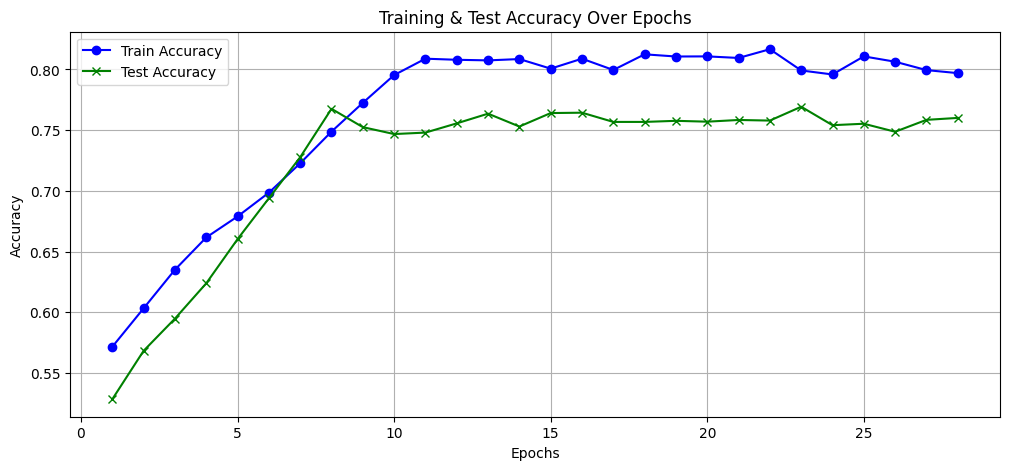

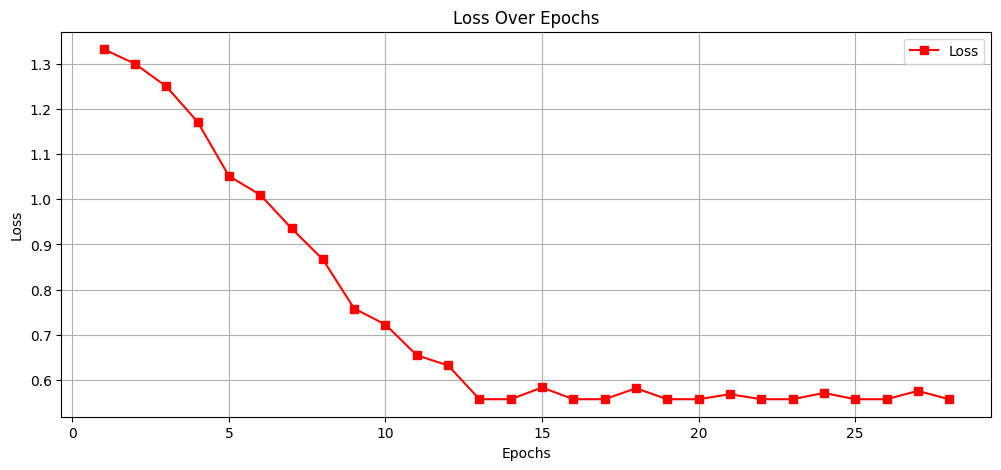

In [ ]:
import matplotlib.pyplot as plt

# ✅ Plotting Training and Test Accuracy
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='blue')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='x', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Plotting Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, loss, label='Loss', marker='s', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -------------------------------
# ✅ Import Libraries
# -------------------------------
import os
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
import h5py
from tqdm import tqdm

# -------------------------------
# ✅ Constants
# -------------------------------
HDF5_FILE_PATH = '/kaggle/input/quark-gluon-ds/quark-gluon_data-set_n139306.hdf5'
MODEL_PATH = '/kaggle/input/clf-model/best_model_clf.pt'
K = 5  # Nearest neighbors for kNN graph
NUM_IMAGES = 100  # Last 100 images for inference

# -------------------------------
# ✅ Load the Trained Model
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Model Definition (DGCNN architecture)
class DGCNN(torch.nn.Module):
    def __init__(self, num_features):
        super(DGCNN, self).__init__()
        self.conv1 = torch.nn.Linear(num_features, 128)
        self.conv2 = torch.nn.Linear(128, 64)
        self.fc = torch.nn.Linear(64, 2)  # Binary classification: Quark vs Gluon

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.mean(x, dim=0)  # Global pooling
        x = self.fc(x)
        return torch.softmax(x, dim=0)

# ✅ Initialize and load model
model = DGCNN(num_features=5).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("✅ Model loaded successfully!")

# -------------------------------
# ✅ Preprocessing Functions
# -------------------------------
def knn_graph(x, k=5):
    """
    Constructs a kNN graph from node features.
    Args:
        x (torch.Tensor): Node features [num_nodes, num_features].
        k (int): Number of neighbors.
    Returns:
        edge_index (torch.Tensor): [2, num_edges].
    """
    x_np = x.cpu().numpy()
    tree = cKDTree(x_np)

    _, neighbors = tree.query(x_np, k=k + 1)  # k+1 to include self
    edge_index = []

    for i, n in enumerate(neighbors):
        for j in n[1:]:  # Skip self-loop
            edge_index.append([i, j])
            edge_index.append([j, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    return edge_index

def preprocess_image(img):
    """
    Preprocesses an image into point cloud and constructs kNN graph.
    Args:
        img (np.array): The 3D image array.
    Returns:
        Data: PyG Data object with the graph.
    """
    # ✅ Extract non-zero pixels
    non_zero_mask = np.any(img != 0, axis=-1)
    y_coords, x_coords = np.where(non_zero_mask)

    # ✅ Extract intensity features (ECAL, HCAL, Tracks)
    ecal = img[non_zero_mask][:, 0]
    hcal = img[non_zero_mask][:, 1]
    tracks = img[non_zero_mask][:, 2]

    # ✅ Normalize features
    features = np.column_stack((ecal, hcal, tracks))
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)

    # ✅ Create Point Cloud DataFrame
    point_cloud = pd.DataFrame({
        "x": x_coords,
        "y": y_coords,
        "ecal": features_normalized[:, 0],
        "hcal": features_normalized[:, 1],
        "tracks": features_normalized[:, 2]
    })

    # ✅ Create PyTorch Tensor
    x_tensor = torch.tensor(point_cloud[['x', 'y', 'ecal', 'hcal', 'tracks']].values, dtype=torch.float)

    # ✅ Construct kNN graph
    edge_index = knn_graph(x_tensor, k=K)

    # ✅ Create PyG Data object
    graph = Data(x=x_tensor, edge_index=edge_index)

    return graph


# -------------------------------
# ✅ Load Images from HDF5
# -------------------------------
def load_last_n_images(hdf5_file, n=100):
    """
    Loads the last `n` images from the HDF5 dataset.
    Args:
        hdf5_file (str): Path to the HDF5 file.
        n (int): Number of images to load.
    Returns:
        images, labels
    """
    images = []
    labels = []

    with h5py.File(hdf5_file, 'r') as f:
        if 'X_jets' in f and 'y' in f:
            total_images = f['X_jets'].shape[0]

            # ✅ Select the last `n` images
            start_idx = max(0, total_images - n)

            images = f['X_jets'][start_idx:]
            labels = f['y'][start_idx:]
            print(f"✅ Loaded {len(images)} images with labels from HDF5")
        else:
            print("⚠️ Dataset not found.")

    return images, labels

# -------------------------------
# ✅ Inference and Display
# -------------------------------
images, labels = load_last_n_images(HDF5_FILE_PATH, n=NUM_IMAGES)

# ✅ Inference Loop
correct = 0
total = len(labels)

for i, (img, actual_label) in enumerate(tqdm(zip(images, labels), total=NUM_IMAGES, desc="Predicting")):
    # ✅ Preprocess image
    graph = preprocess_image(img)
    graph = graph.to(device)

    # ✅ Perform inference
    with torch.no_grad():
        output = model(graph)
        predicted_label = torch.argmax(output).item()

    # ✅ Accuracy calculation
    if predicted_label == actual_label:
        correct += 1

    # ✅ Print result
    print(f"🟢 **Image {i + 1}/{NUM_IMAGES}:** Actual: {actual_label} | 🔥 Predicted: {predicted_label}")

# ✅ Compute final accuracy
accuracy = correct / total
print(f"\n✅ **Predictions Completed:**")
print(f"🎯 **Accuracy:** {accuracy * 100:.2f}% ")


✅ Model loaded successfully!

🔥 **Preprocessing Outputs:**
✅ Loaded 100 images from HDF5.
✅ Preprocessing completed successfully!
✅ Graphs constructed with kNN edges (k=5).

🔥 **Prediction Results:**



Simulating: 100%|██████████| 100/100 [00:00<00:00, 6849.07it/s]

🟢 **Actual:** 0.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.0 | 🔥 **Predicted:** 0.0
🟢 **Actual:** 1.0 | 🔥 **Predicted:** 1.0
🟢 **Actual:** 0.